In [ ]:
!pip install --quiet norse 
!pip install --quiet torch
!pip install --quiet torchvision

     |████████████████████████████████| 92kB 10.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
% cd "/content/drive/MyDrive/Norse SNN/Speach/"
% ls

/content/drive/MyDrive/Norse SNN/Speach
 checkpoints/
'CNN Russian_Speach_Digit_0-9.ipynb'
'code 3conv zeros.ipynb'
'code Russian digit 98 acc check point.ipynb'
'code Speech command comm.ipynb'
'code Speech command digits.ipynb'
'code Speech TIMIT phoneme.ipynb'
'code Speech TIMIT words.ipynb'
 data/
 NB/
'Quant code Speech TIMIT words.ipynb'
'Копия code 3conv zeros.ipynb'
'Копия code.ipynb'


In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data


import torchvision

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import transforms


import numpy as np
import matplotlib.pyplot as plt
import importlib
from tqdm.notebook import tqdm, trange

#norse
import norse
from norse.torch import LIFCell, LILinearCell  
from norse.torch.module import LILinearCell, LIFParameters, LIState, LIFFeedForwardState, SequentialState, LICell

from norse.torch.module.encode  import ConstantCurrentLIFEncoder, PoissonEncoder, SpikeLatencyLIFEncoder


from typing import NamedTuple


In [ ]:
BATCH_SIZE = 50
T = 48
LR = 0.001

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('select device:', DEVICE)

select device: cuda


## Dataset


### transforms

In [ ]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.13,), (0.2,)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.13,), (0.2,)),
])

### CIFAR10

In [ ]:
def load_CIFAR10(path="./data", BATCHSIZE = BATCH_SIZE, transformtrain=transform_train, transformtest=transform_test):
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(
                root=path, train=True, download=True, transform=transformtrain
            ),
        batch_size=BATCHSIZE,
        shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(
                root=path, train=False, transform=transform_test
            ),
        batch_size=BATCHSIZE,
        shuffle=False
    )
    return train_loader, test_loader

In [ ]:
def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

def print_CIFAR10(train_loader):

    images, labels = iter(train_loader).next()


    images1, labels1 = images[:3], labels[:3]
    images2, labels2 = images[3:6], labels[3:6]

    fig, axes = plt.subplots(1, len(images1), figsize=(12,12))
    for idx, image in enumerate(images1):
        axes[idx].imshow(convert_to_imshow_format(image))
        axes[idx].set_title(classes[labels1[idx]])
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])

    fig, axes = plt.subplots(1, len(images2), figsize=(12,12))
    for idx, image in enumerate(images2):
        axes[idx].imshow(convert_to_imshow_format(image))
        axes[idx].set_title(classes[labels2[idx]])
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])   


### EMNIST

In [ ]:
def load_EMNIST(path="./data", split = 'mnist', BATCHSIZE = BATCH_SIZE, transformtrain=transform_train, transformtest=transform_test):
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.EMNIST(
            root=path, train=True, download=True, transform=transform_train,
            split = split
        ),
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.EMNIST(
            root=path, train=False, transform=transform_test,
            split = split
        ),
        batch_size=BATCH_SIZE,
        shuffle=False
    )
    return train_loader, test_loader

In [ ]:
def print_EMNIST(train_loader):
    images, labels = iter(train_loader).next()
    images1, labels1 = images[:10], labels[:10]
    grid_img = torchvision.utils.make_grid(images1, nrow=5)
    plt.imshow(grid_img.permute(1, 2, 0))

### Data loader

In [ ]:
def load_split_train_test(datadir = "./data/Russian_Speach_Digit_0-9 (spec, low)", valid_size = .2, batch_size=BATCH_SIZE):
    print('batch_size', batch_size)
    train_transforms = transforms.Compose([transforms.Resize(28),
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.13,), (0.3,)),
                                           #transforms.Lambda(lambda d: torch.reshape(d[1,:,:], (1, d.shape[1], d.shape[2]) ))
                                          ])
    test_transforms = transforms.Compose([transforms.Resize(28),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.13,), (0.3,)),
                                          #transforms.Lambda(lambda d: torch.reshape(d[1,:,:], (1, d.shape[1], d.shape[2]) ))
                                         ])

    train_data = torchvision.datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = torchvision.datasets.ImageFolder(datadir,
                    transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)


    train_idx, test_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=batch_size)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=batch_size)
                   
    return trainloader, testloader

### Info

In [ ]:
dtype = torch.float16

train_loader, test_loader = load_split_train_test('./data/speech_commands_v0.02 (spec) (digit, 2_5)')
img, _ = train_loader.dataset[0]

classes = train_loader.dataset.classes
print('classes:', classes)
print('train loader size:', len(train_loader))

batch_size 50
classes: ['eight', 'five', 'four', 'nine', 'one', 'seven', 'six', 'three', 'two', 'zero']
train loader size: 400


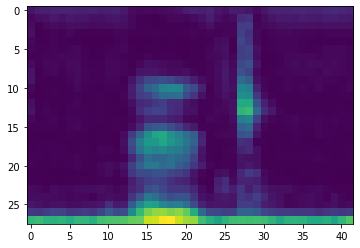

In [ ]:
plt.imshow(train_loader.dataset[11][0][0])

In [ ]:
#print_CIFAR10(train_loader)

## Encode

In [ ]:
def plot_spikes_2d(fig, z):
    T = z.shape[0]
    C = z.shape[1]

    fig.set_size_inches(10,8)
    for c in range(C):
        ax = fig.add_subplot(1, C, c+1, projection='3d')
        s = z[:,c].detach().to_sparse().coalesce()

        ax.invert_yaxis()
        ax.invert_zaxis()
        ax.set_xlim([0,T])
        ax.set_xlabel('time [ms]')
        ax.set_ylabel('spectrogram time')
        ax.set_zlabel('spectrogram Hz')
        ax.scatter(s.indices()[0], s.indices()[2], s.indices()[1], s=1.0, c=s.values())

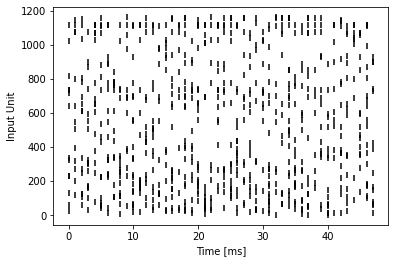

In [ ]:
example_encoder = PoissonEncoder(T)


example_input = example_encoder(img[0])
example_spikes = example_input.reshape(T,img.shape[1]*img.shape[2]).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker='|', color='black')
plt.ylabel('Input Unit')
plt.xlabel('Time [ms]')
plt.show()

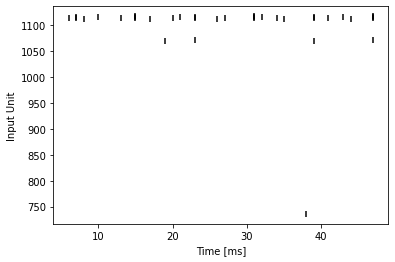

In [ ]:
example_encoder = ConstantCurrentLIFEncoder(T)

example_input = example_encoder(img[0])
example_spikes = example_input.reshape(T,img.shape[1]*img.shape[2]).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker='|', color='black')
plt.ylabel('Input Unit')
plt.xlabel('Time [ms]')
plt.show()

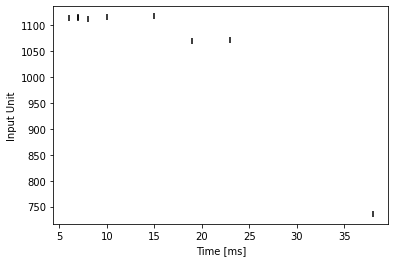

In [ ]:
example_encoder = SpikeLatencyLIFEncoder(T)

example_input = example_encoder(img[0])
example_spikes = example_input.reshape(T,img.shape[1]*img.shape[2]).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker='|', color='black')
plt.ylabel('Input Unit')
plt.xlabel('Time [ms]')
plt.show()

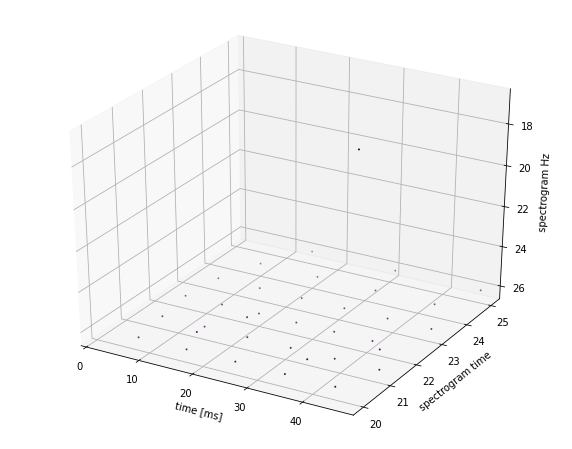

In [ ]:
example_encoder = ConstantCurrentLIFEncoder(T)

example_input = example_encoder(img[0].reshape((1, img.shape[1], img.shape[2])))


fig = plt.figure()

plot_spikes_2d(fig, example_input)

## Convolutional Networks


### CNNs

In [ ]:
class CNN(nn.Module):

  def __init__(self): 
         super(CNN, self).__init__() 
         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)

         self.convlayer1 = nn.Sequential( 
                              nn.Conv2d(32, 64, kernel_size=3, padding=1), 
                              nn.MaxPool2d(kernel_size=2)
                              ) 
         
         self.convlayer2 = nn.Sequential( 
                              nn.Conv2d(64, 96, kernel_size=3, padding=1), 
                              nn.MaxPool2d(kernel_size=2)
                              ) 
         
         self.fclayer1 = nn.Linear(6720, 2048)
         
      

         self.out = nn.Linear(2048, 10)

  def forward(self, x): 
         out = self.conv1(x) 
         out = self.convlayer1(out) 
         out = self.convlayer2(out) 
         out = out.reshape(out.size(0), -1) 
         #print(out.shape)

         out = self.fclayer1(out) 


         return self.out(out)


In [ ]:
class CNN2(nn.Module):

  def __init__(self): 
         super(CNN2, self).__init__() 


         self.conv1 = nn.Sequential( 
                              nn.Conv2d(3, 64, kernel_size=3), 
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2)
                              ) 
         
         
         self.conv2 = nn.Sequential( 
                              nn.Conv2d(64, 96, kernel_size=3), 
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2)
                              ) 
         
         self.conv3 = nn.Sequential( 
                              nn.Conv2d(96, 128, kernel_size=3), 
                              nn.ReLU(),
                              #nn.MaxPool2d(kernel_size=2)
                              ) 
         

         self.drop_out = nn.Dropout() 

         self.fclayer1 = nn.Linear(2048, 768)


        

         self.out = nn.Linear(768, 10)

  def forward(self, x): 
         out = self.conv1(x) 

         out = self.conv2(out) 

         out = self.conv3(out) 

         out = out.reshape(out.size(0), -1) 
         out = self.drop_out(out) 
         #print(out.shape)

         out = self.fclayer1(out) 


         return self.out(out)


### SNNs

In [ ]:
class Model(nn.Module):
    def __init__(self, encoder, snn, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.snn     = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

In [ ]:
class SCNN(nn.Module):
    def __init__(
        self,  num_channels=1, classes = 10, 
        input_size=(28, 28), kernel_size = 3, 
        method="super", alpha=100, 
    ):
        super(SCNN, self).__init__()

        #### -- ####
        self.lif_param = LIFParameters(method=method, alpha=alpha)
        self.features =  torch.tensor(input_size).int()
        self.max_pool2d = torch.nn.MaxPool2d(2)

        self.features2 = None


        print(self.features)

        #### Conv2D ####
        self.conv1 = torch.nn.Conv2d(num_channels, 64, kernel_size, 1)
        self.lif0 = LIFCell(p=LIFParameters(method=method, alpha=alpha))

        #self.features =   (self.features - (kernel_size - 1) ).int()

        #        MaxPool2d(2)
        self.features =   ((self.features -(kernel_size - 1) - 2)/2 + 1).short()
        self.features1 = self.features
        print(self.features)


        self.conv2 = torch.nn.Conv2d(self.conv1.out_channels, 96, kernel_size, 1)
        self.lif1 = LIFCell(p=LIFParameters(method=method, alpha=alpha))

        #self.features =   (self.features - (kernel_size - 1) ).int()

        #        MaxPool2d(2)
        self.features =   ((self.features -(kernel_size - 1) - 2)/2 + 1).short()
        self.features2 = self.features
        print(self.features)


        #### FC ####
        self.features = self.features[0] * self.features[1] * self.conv2.out_channels

        self.fc1 = torch.nn.Linear(self.features, int(self.features/4))
        self.lif2 = LIFCell(p=LIFParameters(method=method, alpha=alpha))

        #### Out ####
        self.out = LILinearCell(int(self.features/4), 10)

    def forward(self, x):
        seq_length = x.shape[0]
        batch_size = x.shape[1]
        
        # specify the initial states
        s0 = s1 = s2 = s3 = s4 = so = None

        voltages = torch.zeros(
            seq_length, batch_size, 10, device=x.device, dtype=x.dtype
        )


        self.z_tmp_1 = torch.zeros(
            seq_length, batch_size, self.conv1.out_channels, self.features1[0], self.features1[1], device=x.device, dtype=x.dtype
        ) 


        self.z_tmp_2 = torch.zeros(
            seq_length, batch_size, self.conv2.out_channels, self.features2[0], self.features2[1], device=x.device, dtype=x.dtype
        ) 


        self.z_tmp_fc = torch.zeros(
            seq_length, batch_size, self.fc1.out_features, device=x.device, dtype=x.dtype
        )         
        for ts in range(seq_length):

            z, s0 = self.lif0(10*self.conv1(x[ts, :]), s0)
            z = self.max_pool2d(z)

            self.z_tmp_1[ts, ...] = z 

            z, s1 = self.lif1(self.conv2(z), s1)
            z = self.max_pool2d(z)

            self.z_tmp_2[ts, ...] = z


            z = z.view(-1, self.features)


            z, s3 = self.lif2(self.fc1(z), s3)

            self.z_tmp_fc[ts, ...] = z



            voltages[ts, :, :], so = self.out(z, so)


        return voltages

In [ ]:
def decode(x):
    x, _ = torch.max(x, 0)
    return F.log_softmax(x)

## Train test

In [ ]:
def evalute(model, test_loader):
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for img, target in tqdm(test_loader):
          
            out = model(img.to(DEVICE))
            
            pred = out.max(1)[1].detach().cpu().numpy()
            target = target.cpu().numpy()
            correct += (pred==target).sum()
            total += len(target)


    return 100*correct / total

In [ ]:
def train(model, train_loader, optimizer):
      model.train()
      for img, target in tqdm(train_loader):
          img, target = img.to(DEVICE), target.to(DEVICE)

          optimizer.zero_grad()

          out = model(img)

          loss = F.nll_loss(out, target)
          
          loss.backward()

          optimizer.step()

      return loss.item() 

In [ ]:
def train_test_loop(model, train_loader, test_loader, opt = 'SGD', EPOCH = 1, lr = 0.01, momentum=0.9 ):
    print('Train model')
    
    if opt == 'SGD':
      optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=1e-4)
    elif opt == 'Adam':
      optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
      print('Unknown optim', opt)


    model.to(DEVICE)

    best_acc = evalute(model, test_loader)
    print('\nAccuracy now: ', best_acc)
    
    for epoch in range(1,EPOCH+1):
        print("\nEpoch %d/%d"%(epoch, EPOCH))

        loss = train(model, train_loader, optimizer)
        
        acc = evalute(model, test_loader)
        
        print("Accuracy: ", acc)

        if best_acc < acc:
          print('Save', best_acc,'-->', acc)
          torch.save( model, './checkpoints/CNN digits cp.pth')
          best_acc = acc
          
        print()

    model = torch.load('./checkpoints/CNN digits cp.pth')
    print("\nBest Acc=%.4f"%(best_acc))

## Train test loop

In [ ]:
model = Model(
    encoder= ConstantCurrentLIFEncoder(T),
    snn=SCNN(num_channels = img.shape[0], classes = len(classes), input_size = img[0].shape),
    decoder=decode
).to(DEVICE)



tensor([28, 42], dtype=torch.int32)
tensor([13, 20], dtype=torch.int16)
tensor([5, 9], dtype=torch.int16)


In [ ]:
train_test_loop(model, train_loader, test_loader, opt = 'Adam', EPOCH = 10, lr = LR/2)

Train model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until




Accuracy now:  9.92

Epoch 1/10



Accuracy:  59.94
Save 9.92 --> 59.94


Epoch 2/10



Accuracy:  71.92
Save 59.94 --> 71.92


Epoch 3/10



Accuracy:  77.66
Save 71.92 --> 77.66


Epoch 4/10



Accuracy:  77.76
Save 77.66 --> 77.76


Epoch 5/10



Accuracy:  82.04
Save 77.76 --> 82.04


Epoch 6/10



Accuracy:  79.58


Epoch 7/10



Accuracy:  84.04
Save 82.04 --> 84.04


Epoch 8/10



Accuracy:  84.8
Save 84.04 --> 84.8


Epoch 9/10



Accuracy:  85.5
Save 84.8 --> 85.5


Epoch 10/10



Accuracy:  86.26
Save 85.5 --> 86.26


Best Acc=86.2600


In [ ]:
train_test_loop(model, train_loader, test_loader, opt = 'Adam', EPOCH = 5, lr = LR/10)

Train model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until




Accuracy now:  86.26

Epoch 1/5



Accuracy:  87.42
Save 86.26 --> 87.42


Epoch 2/5



Accuracy:  87.66
Save 87.42 --> 87.66


Epoch 3/5



Accuracy:  87.72
Save 87.66 --> 87.72


Epoch 4/5



Accuracy:  87.86
Save 87.72 --> 87.86


Epoch 5/5



Accuracy:  88.14
Save 87.86 --> 88.14


Best Acc=88.1400


In [ ]:
train_test_loop(model, train_loader, test_loader, opt = 'Adam', EPOCH = 5, lr = LR/15)

Train model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until




Accuracy now:  88.14

Epoch 1/5



Accuracy:  87.78


Epoch 2/5



Accuracy:  88.02


Epoch 3/5



Accuracy:  87.98


Epoch 4/5



Accuracy:  88.06


Epoch 5/5



Accuracy:  88.38
Save 88.14 --> 88.38


Best Acc=88.3800


In [ ]:
model = torch.load('./checkpoints/snn digits cp.pth')
evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


88.38

In [ ]:
evalute(model, train_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


97.35

In [ ]:
model = torch.load('./checkpoints/snn digits 3.pth')
evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


89.4

In [ ]:
train_test_loop(model, train_loader, test_loader, opt = 'Adam', EPOCH = 5, lr = LR/26)

Train model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until




Accuracy now:  89.4

Epoch 1/5



Accuracy:  89.62
Save 89.4 --> 89.62


Epoch 2/5



Accuracy:  88.94


Epoch 3/5



Accuracy:  89.54


Epoch 4/5



Accuracy:  89.3


Epoch 5/5



Accuracy:  89.48


Best Acc=89.6200


In [ ]:
torch.save( model, './checkpoints/snn digits 89_6.pth')

In [ ]:
train_test_loop(model, train_loader, test_loader, opt = 'Adam', EPOCH = 3, lr = LR/24)

Train model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until




Accuracy now:  89.48

Epoch 1/3



Accuracy:  89.26


Epoch 2/3



Accuracy:  89.06


Epoch 3/3



Accuracy:  89.04


Best Acc=89.4800


In [ ]:
model = torch.load('./checkpoints/snn digits 89_6.pth')
evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


89.48

In [ ]:
evalute(model, train_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


92.61

In [ ]:
cnn = CNN()

In [ ]:
train_test_loop(cnn, train_loader, test_loader, opt = 'Adam', EPOCH = 20, lr = LR/2)

Train model




Accuracy now:  9.5

Epoch 1/20



Accuracy:  9.94
Save 9.5 --> 9.94


Epoch 2/20



Accuracy:  9.94


Epoch 3/20



Accuracy:  9.94


Epoch 4/20



Accuracy:  9.94


Epoch 5/20



Accuracy:  9.94


Epoch 6/20



Accuracy:  9.94


Epoch 7/20



Accuracy:  9.94


Epoch 8/20



Accuracy:  9.94


Epoch 9/20



Accuracy:  9.72


Epoch 10/20



Accuracy:  9.72


Epoch 11/20



Accuracy:  9.94


Epoch 12/20



Accuracy:  9.72


Epoch 13/20



Accuracy:  9.72


Epoch 14/20



Accuracy:  9.72


Epoch 15/20



Accuracy:  9.72


Epoch 16/20



Accuracy:  9.94


Epoch 17/20



Accuracy:  9.94


Epoch 18/20



Accuracy:  9.94


Epoch 19/20



Accuracy:  9.72


Epoch 20/20



Accuracy:  9.72


Best Acc=9.9400
